In [2]:
# Read and Write PFiles
#
# Requires the pfile_utils in the path. On KTH machines run
# module add quicknet pfile_utils
# If you are performing Lab 3B in the DT2118 Speech and Speaker Recognition course, the
# above commands are automatically run when you run source tools/modules
#
# (C) 2016 Giampiero Salvi <giampi@kth.se>

import subprocess
import numpy as np
import sys
import os
import cPickle, gzip
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

def pfile_read(filename):
    """ Reads the data in the PFile filename

    Returns 4 arrays:
    utt_ids: utterance ids repeated for every frame (num_frames)
    frame_ids: frame ids (num_frames)
    features: array (num_frames, num_features) of feature values
    labels: array (num_frames, num_labels) of labels (usually num_labels=1) 

    See also pfile_write   
    """
    proc = subprocess.Popen('pfile_info -i '+filename, shell=True, stdout=subprocess.PIPE)
    res = proc.stdout.read()
    _, info = res.splitlines()
    infoa = info.split(' ')
    num_utts = int(infoa[0])
    num_frames = int(infoa[2])
    num_labels = int(infoa[4])
    num_features = int(infoa[6])
    proc = subprocess.Popen('pfile_print -q -i '+filename, shell=True, stdout=subprocess.PIPE)
    data = np.loadtxt(proc.stdout)
    utt_ids = data[:,0]
    frame_ids = data[:,1]
    features = data[:,2:(num_features+2)]
    labels = data[:, (num_features+2):]
    assert labels.shape[1] == num_labels
    return utt_ids, frame_ids, features, labels

In [3]:
pred_file = 'dnn.classify.pickle.gz'
pfile = 'test_FBANK_0.pfile'

pred_mat = cPickle.load(gzip.open(pred_file, 'rb'))

utt_ids, frame_ids, test_data, test_labels = pfile_read(pfile)

In [26]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

Frame by frame error rate: 16.99%


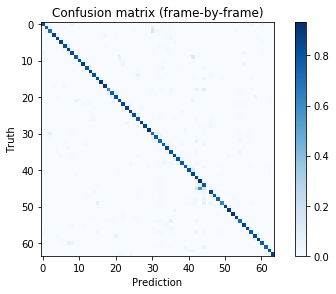

In [29]:
frame_mpost = np.argmax(pred_mat, axis=1)
frame_labels = np.transpose(test_labels).flatten()

frame_err = np.count_nonzero(frame_mpost - frame_labels) * 1. / len(frame_mpost)
# output the final error rate
print('Frame by frame error rate: %2.2f%%' % (frame_err * 100.))

frame_cm = metrics.confusion_matrix(frame_labels, frame_mpost)
frame_cm_normalized = frame_cm.astype('float') / frame_cm.sum(axis=1)[:, np.newaxis]

#plt.figure()
plot_confusion_matrix(frame_cm_normalized, title="Confusion matrix (frame-by-frame)")
#plt.show()

In [22]:
mapping = {}
with open('state2id.lst') as f:
    for line in f:
        parts = line.split(' ')
        phoneme = parts[0].split('_')[0]
        state = int(parts[1])
        mapping[state] = phoneme

Phoneme error: 9.77%


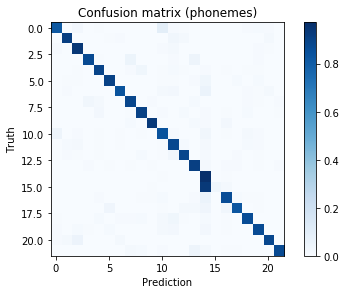

In [31]:
# phoneme level evaluation
phoneme_mpost = np.array([mapping[x] for x in frame_mpost])
phoneme_labels = np.array([mapping[x] for x in frame_labels])

phoneme_err = 1.0 * np.count_nonzero(phoneme_mpost != phoneme_labels) / len(phoneme_mpost)
print('Phoneme error: %2.2f%%' % (100.0 * phoneme_err))

phoneme_cm = metrics.confusion_matrix(phoneme_labels, phoneme_mpost)
phoneme_cm_normalized = phoneme_cm.astype('float') / phoneme_cm.sum(axis=1)[:, np.newaxis]

plot_confusion_matrix(phoneme_cm_normalized, title="Confusion matrix (phonemes)")